In [ ]:
!pip install nlp

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


In [ ]:
!pip install datasets==2.9.0

In [ ]:
#dataset = nlp.load_dataset("emotion")
from datasets import load_dataset
dataset = load_dataset("emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train["label"]

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[0], labels[0]
# labels: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

('i didnt feel humiliated', 0)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

In [ ]:
tokenizer.fit_on_texts(tweets)
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
lengths = [len(t.split(" ")) for  t in tweets]

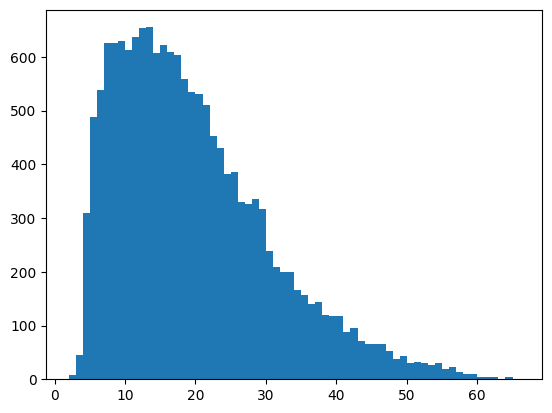

In [ ]:
plt.hist(lengths, bins= len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating="post", padding= "post", maxlen=maxlen)
    return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
classes = set(labels)
print(classes)
# sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

{0, 1, 2, 3, 4, 5}


<function matplotlib.pyplot.show(close=None, block=None)>

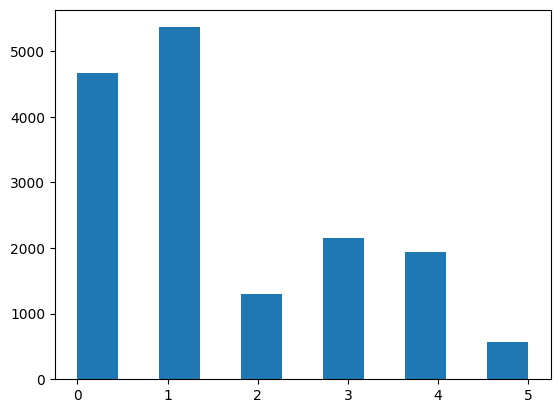

In [ ]:
plt.hist(labels, bins=11)
plt.show

In [ ]:
# если нужно присвоить индекс-лейбл вместо слов - обязательно
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)
print(train_labels[0])

0


In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation="softmax")
])

model.compile(

    loss="sparse_categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 43s 62ms/step - loss: 1.4128 - accuracy: 0.4084 - val_loss: 0.9777 - val_accuracy: 0.6355
Epoch 2/20
500/500 [==============================] - 10s 21ms/step - loss: 0.6547 - accuracy: 0.7692 - val_loss: 0.5100 - val_accuracy: 0.8485
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2908 - accuracy: 0.9066 - val_loss: 0.3825 - val_accuracy: 0.8795
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1816 - accuracy: 0.9429 - val_loss: 0.3855 - val_accuracy: 0.8860
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1212 - accuracy: 0.9622 - val_loss: 0.3603 - val_accuracy: 0.8910
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0934 - accuracy: 0.9718 - val_loss: 0.3829 - val_accuracy: 0.8835
Epoch 7/20
500/500 [==============================] - 7s 15ms/step - loss: 0.0701 - accuracy: 0.9781 - val_loss: 0.4425 - val_accuracy: 0.89

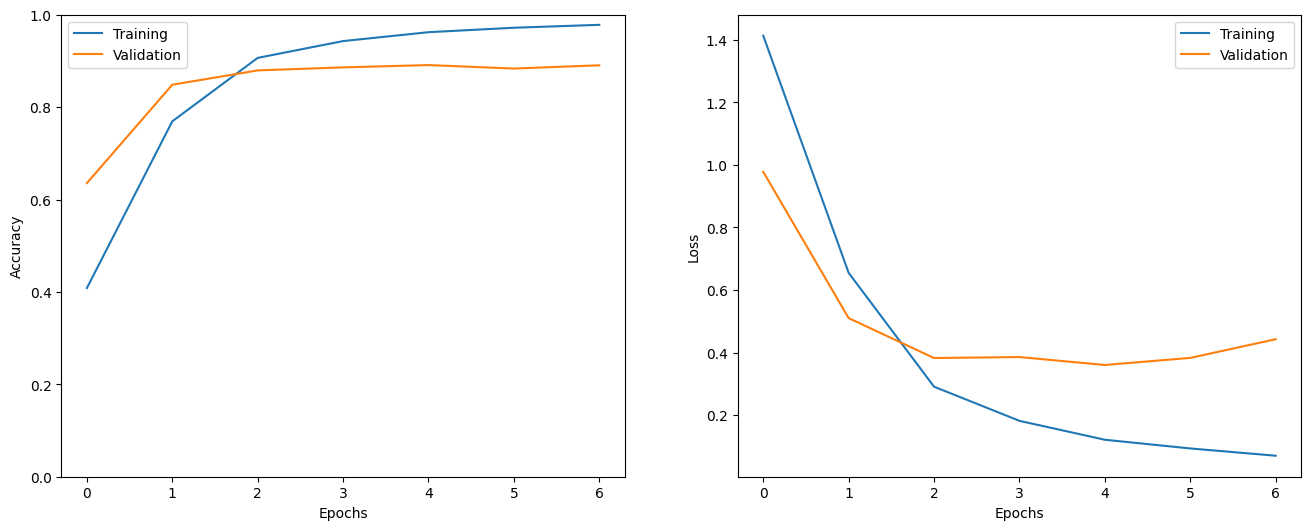

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.4253 - accuracy: 0.8870


In [ ]:
i = random.randint(0, len(test_labels) - 1)
print("Sentence:", test_tweets[i])
print("Emotion:", index_to_class[test_labels[i]])
prediction = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(prediction).astype('uint8')]

print('Predicted emotion:', pred_class)

Sentence: i feel like this beats out just about any popular high end foundation on the market at either ulta or sephora
Emotion: 1
1/1 [==============================] - 0s 24ms/step
Predicted emotion: 1


In [ ]:
preds=model.predict(test_seq)
classes_test_seq=np.argmax(preds,axis=1)

63/63 [==============================] - 1s 9ms/step


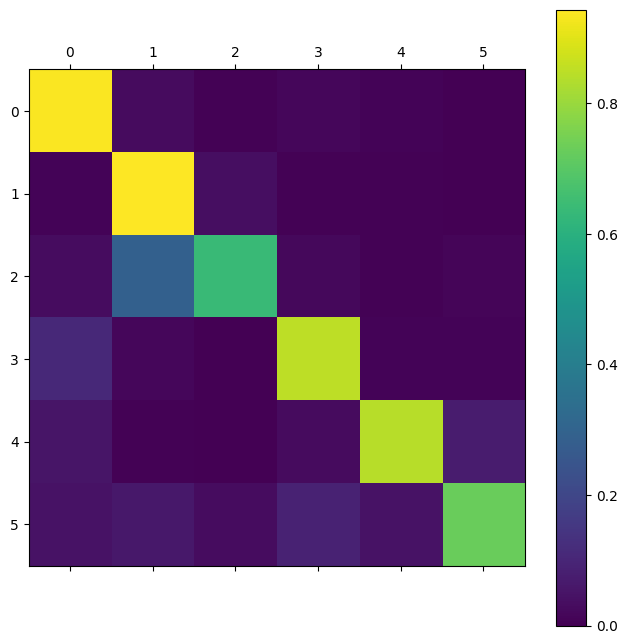

In [ ]:
show_confusion_matrix(test_labels, classes_test_seq, list(classes))